In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Wed Jul 31 16:38:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   44C    P0    57W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [3]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_split.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)

# Assuming 'split' column contains strings 'train', 'validation', 'test'
# Filter the loaded dataset into subsets
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')

Using custom data configuration default-31dfe7adddcf5ced
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 111.64it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ad71be204b279b28.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e7b6b615907c24ca.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-bee802838a3bfaea.arrow


In [4]:
train_dataset

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
    num_rows: 1623
})

In [5]:
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

In [6]:
columns_to_keep = ['claim', 'premise', 'label','category','count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat']
all_columns = train_dataset.column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [7]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-09f98be504f641e8.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-75a2e5f266438c59.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-dfc9496ac5f6c678.arrow


Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [8]:
len(dataset['val']['claim'])

465

In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='TehranNLP-org/electra-base-mnli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        premise = item['premise'].lower().replace('\n', '').replace('[','').replace(']','')
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        item['claim']=claim
        item['premise']=premise        
        # Tokenize the texts
        inputs = self.tokenizer(
             premise, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': premise  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item




In [11]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [12]:
model_name = "TehranNLP-org/electra-base-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model = model.to(device)

In [13]:
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [15]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
    num_rows: 1623
})

In [16]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [17]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [18]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [19]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [20]:
tdata.__getitem__(0)

{'input_ids': tensor([  101,  1025,  4895,  7724,  2401,  1527,  1010,  1050,  1012,  1025,
         11737, 21128,  1527,  1010,  1045,  1012,  1025, 23341,  2050,  1527,
         12849,  9035,  1527,  1010,  1052,  1012,  1025, 11721, 19716, 22360,
          9035,  1527,  1010,  1049,  1012,  1025,  9761, 29147,  6777,  2401,
          1527,  1010,  1051,  1012,  1025, 24728,  3683,  6460,  9035,  1527,
          1010,  1046,  1012,  3581,  2378, 19023,  2063,  1998,  2026, 12171,
          2232,  6827, 20631,  1998,  6402, 28647, 11865,  4168,  2114, 12702,
          1011,  4864,  1997, 17266,  7941, 17093,  2015,  1012,  9467,  6633,
          1010,  1045,  1012,  6887, 22123, 23555,  7712,  2389,  1004, 17261,
          4022,  2015,  1997, 14163, 12171,  5003, 24103,  1006,  1012, 23060,
          8524,  6024,  6911,  1998, 10047, 23041, 11439,  9048,  2278,  3896,
          1997,  2599,  1998,  2037,  2572, 20806, 21223,  2007,  2026, 12171,
          2232,  1006,  4012,  4328,  8

In [21]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

device = torch.device("cuda:0")

training_args = TrainingArguments(
    output_dir=f'/home/elson/12.2.3_electra/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to("cuda:0"),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)
print(f"Model is on device: {next(model.parameters()).device}")
# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/12.2.3_electra/best_model')
tokenizer.save_pretrained(f'/home/elson/12.2.3_electra/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Model is on device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.840100,0.803087,0.677419,0.382078,0.517787,0.677419,0.579953
2,0.605600,0.866526,0.640860,0.480519,0.643979,0.640860,0.637642
3,0.329700,1.185673,0.662366,0.514081,0.665794,0.662366,0.660300
4,0.107900,1.588378,0.612903,0.489259,0.644734,0.612903,0.626676
5,0.229200,1.622338,0.647312,0.499536,0.649309,0.647312,0.647851
6,0.121900,2.033986,0.653763,0.492034,0.643709,0.653763,0.647902
7,0.087300,2.011122,0.640860,0.468348,0.641503,0.640860,0.636534
8,0.026800,2.244899,0.634409,0.509686,0.659183,0.634409,0.644591
9,0.014400,2.166771,0.681720,0.532443,0.674197,0.681720,0.677337
10,0.003100,2.376202,0.653763,0.514912,0.664063,0.653763,0.658153


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
/home/elson/factcheck/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to /home/elson/12.2.3_electra/checkpoint-51
Configuration saved in /home/elson/12.2.3_electra/checkpoint-51/config.json
Model weights saved in /home/elson/12.2.3_electra/checkpoint-51/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/12.2.3_electra/checkpoint-102
Configuration saved in /home/elson/12.2.3_electra/checkpoint-102/config.json
Model weights saved in /home/elson/12.2.3_electra/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to

Configuration saved in /home/elson/12.2.3_electra/best_model/config.json
Model weights saved in /home/elson/12.2.3_electra/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/12.2.3_electra/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/12.2.3_electra/best_model/special_tokens_map.json


('/home/elson/12.2.3_electra/best_model/tokenizer_config.json',
 '/home/elson/12.2.3_electra/best_model/special_tokens_map.json',
 '/home/elson/12.2.3_electra/best_model/vocab.txt',
 '/home/elson/12.2.3_electra/best_model/added_tokens.json',
 '/home/elson/12.2.3_electra/best_model/tokenizer.json')

In [23]:
model_path = "/home/elson/12.2.3_electra/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/12.2.3_electra/best_model/config.json
Model config ElectraConfig {
  "_name_or_path": "/home/elson/12.2.3_electra/best_model/",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "finetuning_task": "mnli",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "fi

In [24]:
print(test_results)

PredictionOutput(predictions=array([[-2.73   ,  0.8125 ,  2.152  ],
       [-4.105  ,  5.88   , -1.229  ],
       [-4.02   ,  6.836  , -2.38   ],
       [ 2.078  ,  1.715  , -4.43   ],
       [-0.3352 ,  4.984  , -4.96   ],
       [-3.928  ,  6.844  , -2.5    ],
       [-0.5156 ,  5.484  , -5.312  ],
       [-4.6    ,  6.758  , -1.562  ],
       [-3.873  ,  6.797  , -2.506  ],
       [ 1.73   ,  0.884  , -2.932  ],
       [-4.246  ,  6.855  , -2.053  ],
       [-0.1039 ,  5.227  , -5.645  ],
       [ 0.8013 ,  2.69   , -3.791  ],
       [-4.43   ,  6.793  , -1.809  ],
       [-4.82   ,  3.787  ,  1.657  ],
       [ 2.555  ,  1.717  , -5.22   ],
       [-3.215  ,  6.48   , -2.92   ],
       [-5.1    ,  4.582  ,  1.147  ],
       [-0.8994 ,  5.56   , -4.89   ],
       [-3.32   ,  6.688  , -3.021  ],
       [-3.906  ,  6.395  , -1.926  ],
       [-4.48   ,  6.773  , -1.712  ],
       [-3.691  ,  6.715  , -2.5    ],
       [ 3.521  , -4.11   ,  0.2168 ],
       [-3.084  ,  6.332  , -2.754 

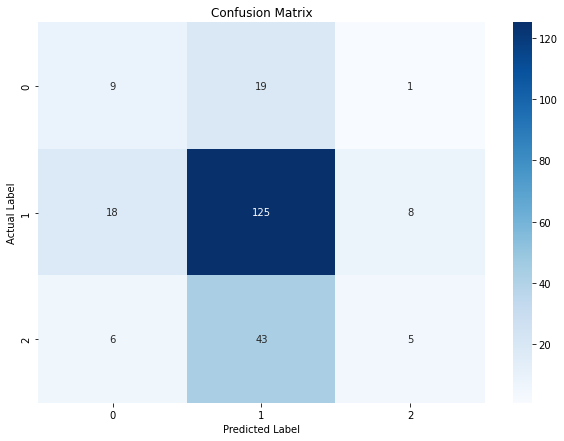

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [26]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/12.2.3_results.csv', index=False)

In [27]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [28]:
correct_classification_counts

General Health           34
Fitness                  12
Cancer                   12
Bone health              11
Throat                    9
Diabetes                  9
Cardiovascular Health     7
Neurological health       7
Skin                      7
Hair                      6
Ear                       6
Eye                       5
Blood                     4
Women' s Health           4
Mental Health             2
COVID                     1
Muscles                   1
Men's health              1
Vascular                  1
Name: Category, dtype: int64

In [29]:
misclassification_counts

Skin                     17
General Health           17
Bone health              10
Hair                      6
Blood                     5
Muscles                   5
Cardiovascular Health     5
Men's health              5
COVID                     5
Eye                       4
Diabetes                  3
Dental Health             3
Fitness                   3
Neurological health       2
Vascular                  2
Women' s Health           2
Mental Health             1
Name: Category, dtype: int64